# 3.5

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models


**Data Loader**

In [2]:
def load_data(batch_size=128, color_jitter=False):
    """Load CIFAR-100 dataset with optional color jitter augmentations for training."""
    if color_jitter:
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
            transforms.Resize(224),
        ])
    else:
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
            transforms.Resize(224),
        ])

    transform_test = transforms.Compose([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
        transforms.Resize(224),
    ])
    
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return trainloader, testloader

**CRD Models**

In [3]:
# Teacher Model with CRD
class TeacherModelCRD(nn.Module):
    def __init__(self):
        super().__init__()
        model = models.vgg16(pretrained=True)
        self.features = model.features
        self.avgpool = model.avgpool
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 100)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    def get_features(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier[:-1](x)  
        return x

    
class StudentModelCRD(nn.Module):
    def __init__(self):
        super().__init__()
        
        vgg11 = models.vgg11(pretrained=True)
        self.features = vgg11.features 
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 100) 
        )
        
        self.projection = nn.Sequential(
            nn.Linear(512, 4096), 
            nn.ReLU(True)
        )

        
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        x = self.features(x)  
        x = self.avgpool(x)      
        x = torch.flatten(x, 1)    
        x = self.classifier(x)      
        return x
    
    def get_features(self, x):
        x = self.features(x)      
        x = self.avgpool(x)         
        x = torch.flatten(x, 1)   
        x = self.classifier[:-1](x) 
        x = self.projection(x) 
        return x



Teacher Training

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


def train_model(model, trainloader, testloader, device, epochs=5, save_path='best_model.pth'):
    """Train a model (teacher or student) on CIFAR-100."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    best_acc = 0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with tqdm(total=len(trainloader), desc=f'Training Epoch {epoch + 1}', unit='batch') as pbar:
            for inputs, labels in trainloader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                pbar.set_postfix(loss=running_loss / (pbar.n + 1), acc=100. * correct / total)
                pbar.update(1)
        
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        print(f'Training: Epoch {epoch + 1}, Loss: {epoch_loss:.3f}, Acc: {epoch_acc:.2f}%')
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        acc = 100. * correct / total
        print(f'Epoch {epoch + 1}: Validation Accuracy: {acc:.2f}%')
        
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), save_path)
    
    model.load_state_dict(torch.load(save_path))
    return model

In [5]:
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    accuracy = 100. * correct / total
    return accuracy

In [6]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainloader, testloader = load_data(color_jitter=True)
teacher_model = TeacherModelCRD().to(device)
teacher_model = train_model(teacher_model, trainloader, testloader, device, epochs=7, save_path='best_teacher_crd.pth')

teacher_accuracy_final = evaluate(teacher_model, testloader, device)
print(f'Final Teacher Accuracy on Color-Jittered Data: {teacher_accuracy_final:.2f}%')


100%|██████████| 169001437/169001437 [00:16<00:00, 10084676.69it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 208MB/s] 
Training Epoch 1: 100%|██████████| 391/391 [06:21<00:00,  1.03batch/s, acc=40.7, loss=2.29]

Training: Epoch 1, Loss: 2.291, Acc: 40.73%


Epoch 1: Validation Accuracy: 62.39%


Training Epoch 2: 100%|██████████| 391/391 [06:19<00:00,  1.03batch/s, acc=60.7, loss=1.38]

Training: Epoch 2, Loss: 1.382, Acc: 60.73%


Epoch 2: Validation Accuracy: 66.94%


Training Epoch 3: 100%|██████████| 391/391 [06:19<00:00,  1.03batch/s, acc=67, loss=1.14]  

Training: Epoch 3, Loss: 1.143, Acc: 66.98%


Epoch 3: Validation Accuracy: 69.95%


Training Epoch 4: 100%|██████████| 391/391 [06:19<00:00,  1.03batch/s, acc=71.2, loss=0.987]

Training: Epoch 4, Loss: 0.987, Acc: 71.17%


Epoch 4: Validation Accuracy: 70.27%


Training Epoch 5: 100%|██████████| 391/391 [06:19<00:00,  1.03batch/s, acc=74.3, loss=0.867]

Training: Epoch 5, Loss: 0.867, Acc: 74.27%


Epoch 5: Validation Accuracy: 72.45%


Training Epoch 6: 100%|██████████| 391/391 [06:19<00:00,  1.03batch/s, acc=76.7, loss=0.782]

Training: Epoch 6, Loss: 0.782, Acc: 76.75%


Epoch 6: Validation Accuracy: 73.00%


Training Epoch 7: 100%|██████████| 391/391 [06:19<00:00,  1.03batch/s, acc=78.9, loss=0.706]

Training: Epoch 7, Loss: 0.706, Acc: 78.85%


Epoch 7: Validation Accuracy: 71.77%


/tmp/ipykernel_30/1620034120.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


Final Teacher Accuracy on Color-Jittered Data: 73.14%


In [8]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


_, testloader = load_data(color_jitter=False)
teacher_model = TeacherModelCRD().to(device)
teacher_model.load_state_dict(torch.load('/kaggle/input/bestcrdteacher/pytorch/default/1/best_teacher_crd.pth'))

teacher_accuracy_final = evaluate(teacher_model, testloader, device)
print(f'Final Teacher Accuracy on Non-Jittered Data: {teacher_accuracy_final:.2f}%')


Files already downloaded and verified
Files already downloaded and verified


/tmp/ipykernel_30/2098664327.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_model.load_state_dict(torch.load('/kaggle/input/bestcrdteacher/pytorch/default/1/be

Final Teacher Accuracy on Non-Jittered Data: 73.03%


**Finetuning Student**

In [7]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainloader, testloader = load_data(color_jitter=False)

student_model = StudentModelCRD().to(device)
student_model = train_model(student_model, trainloader, testloader, device, epochs=2, save_path='best_student_crd.pth')

student_accuracy_final = evaluate(student_model, testloader, device)
print(f"Final Student Accuracy on Color-Jittered Data: {student_accuracy_final:.2f}%")


Files already downloaded and verified
Files already downloaded and verified


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:02<00:00, 235MB/s] 
Training Epoch 1: 100%|██████████| 391/391 [03:15<00:00,  2.00batch/s, acc=20.8, loss=3.24]

Training: Epoch 1, Loss: 3.241, Acc: 20.80%


Epoch 1: Validation Accuracy: 47.04%


Training Epoch 2: 100%|██████████| 391/391 [03:14<00:00,  2.01batch/s, acc=42.9, loss=2.08]

Training: Epoch 2, Loss: 2.081, Acc: 42.91%


Epoch 2: Validation Accuracy: 56.21%


/tmp/ipykernel_30/1620034120.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


Final Student Accuracy on Color-Jittered Data: 55.87%


# **CRD TRAINING**

In [6]:
class DistillKL(nn.Module):
    def __init__(self, T):
        super(DistillKL, self).__init__()
        self.T = T

    def forward(self, y_s, y_t):
        p_s = nn.functional.log_softmax(y_s/self.T, dim=1)
        p_t = nn.functional.softmax(y_t/self.T, dim=1)
        loss = nn.KLDivLoss(reduction='batchmean')(p_s, p_t) * (self.T**2)
        return loss

class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, student_features, teacher_features):
        student_features = nn.functional.normalize(student_features, dim=1)
        teacher_features = nn.functional.normalize(teacher_features, dim=1)

        similarity = torch.matmul(student_features, teacher_features.T) / self.temperature
        labels = torch.arange(similarity.size(0), device=similarity.device)
        loss = nn.CrossEntropyLoss()(similarity, labels)
        
        return loss


CRD Student Training

In [7]:
def train_epochs(teacher_model, student_model, trainloader, device, optimizer, kl_criterion, contrastive_criterion, epochs):
    """Train the student model using knowledge distillation over multiple epochs."""
    for epoch in range(epochs):
        student_model.train()
        teacher_model.eval()
        
        total_loss = 0
        total_samples = 0
        losses = [] 

        for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader, desc=f"Training Epoch {epoch + 1}/{epochs}", unit="batch")):
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size = inputs.size(0)
            
            optimizer.zero_grad()
            
            with torch.no_grad():
                teacher_outputs = teacher_model(inputs)
                teacher_features = teacher_model.get_features(inputs)
            
            student_outputs = student_model(inputs)
            student_features = student_model.get_features(inputs)
            
            kl_loss = kl_criterion(student_outputs, teacher_outputs)
            contr_loss = contrastive_criterion(student_features, teacher_features)
            cls_loss = nn.CrossEntropyLoss()(student_outputs, targets)
            
            loss = 0.5 * kl_loss + 0.1 * contr_loss + 0.4 * cls_loss
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * batch_size
            total_samples += batch_size
            losses.append(loss.item())

            if (batch_idx + 1) % 100 == 0:
                print(f'Batch: [{batch_idx + 1}/{len(trainloader)}], '
                      f'Loss: {loss.item():.4f}, '
                      f'KL Loss: {kl_loss.item():.4f}, '
                      f'Contr Loss: {contr_loss.item():.4f}, '
                      f'Cls Loss: {cls_loss.item():.4f}')
        
        average_loss = total_loss / total_samples
        print(f'Epoch [{epoch + 1}/{epochs}], Average Loss: {average_loss:.4f}')
    
    return losses  


In [10]:
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

original_trainloader, original_testloader = load_data(color_jitter=False)

teacher_model = TeacherModelCRD().to(device)
teacher_model.load_state_dict(torch.load('best_teacher_crd.pth'))  
teacher_model.eval()  

student_model = StudentModelCRD().to(device)
student_model.load_state_dict(torch.load('best_student_crd.pth'))
student_model.eval()  

optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-4)

kl_criterion = DistillKL(T=4)  
contrastive_criterion = ContrastiveLoss(temperature=0.07)

num_epochs = 5  
losses = train_epochs(teacher_model, student_model, original_trainloader, device, optimizer, kl_criterion, contrastive_criterion, epochs=num_epochs)

student_accuracy_final = evaluate(student_model, original_testloader, device)
print(f'Final Student Accuracy on Original Data: {student_accuracy_final:.2f}%')


Files already downloaded and verified
Files already downloaded and verified


/tmp/ipykernel_30/2053408205.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_model.load_state_dict(torch.load('best_teacher_crd.pth'))  # Load fine-tuned teache

Batch: [100/391], Loss: 3.3516, KL Loss: 4.7271, Contr Loss: 2.0594, Cls Loss: 1.9551


Training Epoch 1/5:  51%|█████     | 200/391 [05:08<04:53,  1.54s/batch]

Batch: [200/391], Loss: 2.9445, KL Loss: 4.5334, Contr Loss: 1.5650, Cls Loss: 1.3032


Training Epoch 1/5:  77%|███████▋  | 300/391 [07:42<02:20,  1.54s/batch]

Batch: [300/391], Loss: 2.3955, KL Loss: 3.3709, Contr Loss: 1.4273, Cls Loss: 1.4182


Training Epoch 1/5: 100%|██████████| 391/391 [10:01<00:00,  1.54s/batch]


Epoch [1/5], Average Loss: 2.8396


Training Epoch 2/5:  26%|██▌       | 100/391 [02:34<07:28,  1.54s/batch]

Batch: [100/391], Loss: 2.3169, KL Loss: 3.3443, Contr Loss: 1.2610, Cls Loss: 1.2966


Training Epoch 2/5:  51%|█████     | 200/391 [05:08<04:54,  1.54s/batch]

Batch: [200/391], Loss: 2.1052, KL Loss: 2.8031, Contr Loss: 1.1427, Cls Loss: 1.4734


Training Epoch 2/5:  77%|███████▋  | 300/391 [07:42<02:20,  1.54s/batch]

Batch: [300/391], Loss: 1.9950, KL Loss: 2.8020, Contr Loss: 1.0967, Cls Loss: 1.2108


Training Epoch 2/5: 100%|██████████| 391/391 [10:01<00:00,  1.54s/batch]


Epoch [2/5], Average Loss: 2.1406


Training Epoch 3/5:  26%|██▌       | 100/391 [02:34<07:27,  1.54s/batch]

Batch: [100/391], Loss: 1.8689, KL Loss: 2.5298, Contr Loss: 0.9011, Cls Loss: 1.2848


Training Epoch 3/5:  51%|█████     | 200/391 [05:07<04:53,  1.54s/batch]

Batch: [200/391], Loss: 1.9818, KL Loss: 2.5090, Contr Loss: 0.9926, Cls Loss: 1.5700


Training Epoch 3/5:  77%|███████▋  | 300/391 [07:41<02:19,  1.54s/batch]

Batch: [300/391], Loss: 1.7576, KL Loss: 2.5151, Contr Loss: 0.8692, Cls Loss: 1.0328


Training Epoch 3/5: 100%|██████████| 391/391 [10:01<00:00,  1.54s/batch]


Epoch [3/5], Average Loss: 1.8316


Training Epoch 4/5:  26%|██▌       | 100/391 [02:34<07:27,  1.54s/batch]

Batch: [100/391], Loss: 1.6405, KL Loss: 2.0327, Contr Loss: 0.8335, Cls Loss: 1.3519


Training Epoch 4/5:  51%|█████     | 200/391 [05:07<04:53,  1.54s/batch]

Batch: [200/391], Loss: 1.6465, KL Loss: 1.9772, Contr Loss: 0.8375, Cls Loss: 1.4353


Training Epoch 4/5:  77%|███████▋  | 300/391 [07:41<02:19,  1.54s/batch]

Batch: [300/391], Loss: 1.5071, KL Loss: 2.0926, Contr Loss: 0.8853, Cls Loss: 0.9307


Training Epoch 4/5: 100%|██████████| 391/391 [10:01<00:00,  1.54s/batch]


Epoch [4/5], Average Loss: 1.6462


Training Epoch 5/5:  26%|██▌       | 100/391 [02:34<07:28,  1.54s/batch]

Batch: [100/391], Loss: 1.4782, KL Loss: 1.9216, Contr Loss: 0.8457, Cls Loss: 1.0819


Training Epoch 5/5:  51%|█████     | 200/391 [05:08<04:53,  1.54s/batch]

Batch: [200/391], Loss: 1.4259, KL Loss: 1.8328, Contr Loss: 0.7762, Cls Loss: 1.0798


Training Epoch 5/5:  77%|███████▋  | 300/391 [07:41<02:20,  1.54s/batch]

Batch: [300/391], Loss: 1.5548, KL Loss: 1.9469, Contr Loss: 0.8442, Cls Loss: 1.2423


Training Epoch 5/5: 100%|██████████| 391/391 [10:01<00:00,  1.54s/batch]

Epoch [5/5], Average Loss: 1.5213


Final Student Accuracy on Original Data: 66.88%


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

student_model = StudentModelCRD().to(device)
student_model.load_state_dict(torch.load('/kaggle/input/studentcrdd/pytorch/default/1/best_student_crd.pth'))  # Load fine-tuned teacher model
student_model.eval() 

batch_size = 128
trainloader, testloader = load_data(batch_size=batch_size, color_jitter=True)

accuracy = evaluate(student_model, testloader, device)
print(f"Model Accuracy on Jittered Data: {accuracy:.2f}%")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:19<00:00, 27.3MB/s] 
/tmp/ipykernel_30/2661703552.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for 

100%|██████████| 169001437/169001437 [00:03<00:00, 48741500.63it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Model Accuracy on Jittered Data: 55.85%


# Logit Matching

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd

def train_student(teacher_model, student_model, trainloader, testloader, device, num_epochs=5, temperature=4.0, alpha=0.9):
    """Train the student model using knowledge distillation."""
    criterion = nn.KLDivLoss(reduction='batchmean')
    optimizer = optim.Adam(student_model.parameters(), lr=1e-4)  
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2)

    best_acc = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        student_model.train()
        teacher_model.eval()
        
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(trainloader, desc=f'Training Epoch {epoch + 1}', unit='batch'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            with torch.no_grad():
                teacher_outputs = teacher_model(inputs)
                teacher_probs = F.softmax(teacher_outputs / temperature, dim=1)
            
            student_outputs = student_model(inputs)
            student_log_probs = F.log_softmax(student_outputs / temperature, dim=1)
            
            distillation_loss = criterion(student_log_probs, teacher_probs) * (temperature ** 2)
            student_loss = F.cross_entropy(student_outputs, labels)
            loss = alpha * distillation_loss + (1 - alpha) * student_loss
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = student_outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        student_model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = student_model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        accuracy = 100. * correct / total
        val_losses.append(epoch_loss)  
        val_accuracies.append(accuracy)
        
        print(f'Epoch {epoch + 1}: Loss: {epoch_loss:.3f}, Acc: {epoch_acc:.2f}%')
        print(f'Epoch {epoch + 1} Validation Accuracy: {accuracy:.2f}%')
        
        if accuracy > best_acc:
            best_acc = accuracy
            torch.save(student_model.state_dict(), 'best_student_logits.pth')
        
        scheduler.step()  
    
    LMmetrics = {
        'Train Loss': train_losses,
        'Validation Loss': val_losses,
        'Train Accuracy': train_accuracies,
        'Validation Accuracy': val_accuracies
    }
    LMmetrics_df = pd.DataFrame(LMmetrics)
    LMmetrics_df.to_csv('student_training_metricsLM.csv', index_label='Epoch')

    return student_model, train_losses, val_losses, train_accuracies, val_accuracies

In [12]:
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

original_trainloader, original_testloader = load_data(color_jitter=False)

teacher_model = TeacherModelCRD().to(device)
teacher_model.load_state_dict(torch.load('best_teacher_crd.pth')) 
teacher_model.eval()  

student_model = StudentModelCRD().to(device)
student_model.load_state_dict(torch.load('best_student_crd.pth'))  
student_model.eval() 

student_model, train_losses, val_losses, train_accuracies, val_accuracies = train_student(
    teacher_model, student_model, original_trainloader, original_testloader, device, num_epochs=5
)

student_accuracy_final = evaluate(student_model, original_testloader, device)
print(f'Final Student Accuracy on Original Data: {student_accuracy_final:.2f}%')


Files already downloaded and verified
Files already downloaded and verified


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_30/78031335.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In 

Epoch 1: Loss: 3.725, Acc: 53.04%
Epoch 1 Validation Accuracy: 57.84%


Training Epoch 2: 100%|██████████| 391/391 [05:08<00:00,  1.27batch/s]


Epoch 2: Loss: 2.775, Acc: 58.38%
Epoch 2 Validation Accuracy: 61.30%


Training Epoch 3: 100%|██████████| 391/391 [05:09<00:00,  1.26batch/s]


Epoch 3: Loss: 2.362, Acc: 61.56%
Epoch 3 Validation Accuracy: 62.91%


Training Epoch 4: 100%|██████████| 391/391 [05:09<00:00,  1.26batch/s]


Epoch 4: Loss: 2.111, Acc: 63.74%
Epoch 4 Validation Accuracy: 63.45%


Training Epoch 5: 100%|██████████| 391/391 [05:09<00:00,  1.26batch/s]


Epoch 5: Loss: 1.971, Acc: 64.86%
Epoch 5 Validation Accuracy: 64.81%
Final Student Accuracy on Original Data: 64.96%


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

student_model = StudentModelCRD().to(device)
student_model.load_state_dict(torch.load('/kaggle/input/studentlogits/pytorch/default/1/best_student_logits.pth'))  # Load fine-tuned teacher model
student_model.eval() 

batch_size = 128
trainloader, testloader = load_data(batch_size=batch_size, color_jitter=True)

accuracy = evaluate(student_model, testloader, device)
print(f"Model Accuracy on Jittered Data: {accuracy:.2f}%")

/tmp/ipykernel_30/3980609131.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student_model.load_state_dict(torch.load('/kaggle/input/studentlogits/pytorch/default/1/best

Files already downloaded and verified
Files already downloaded and verified
Model Accuracy on Jittered Data: 64.30%


# HINT 

**Teacher Hint**

In [9]:
class HintTeacherModel(nn.Module):
    def __init__(self):
        super().__init__()
        model = models.vgg16(pretrained=True)
        self.features = model.features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),  
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 100)
        )
        
        # Freeze the model parameters
        for param in model.parameters():
            param.requires_grad = False
        
    def forward(self, x):
        features = self.features(x)
        hint_features = features 
        x = torch.flatten(features, 1)
        logits = self.classifier(x)
        
        return logits, hint_features


**Student Hint**

In [10]:
class HintStudentModel(nn.Module):
    def __init__(self):
        super().__init__()
        model = models.vgg11(pretrained=True)
        self.features = model.features
        
        self.regressor = nn.Conv2d(512, 512, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 2048), 
            nn.BatchNorm1d(2048),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(1024, 100)
        )
        
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)
            
    def forward(self, x):
        features = self.features(x)
        hint_features = self.regressor(features)  # Match teacher's feature dimensions
        
        x = torch.flatten(features, 1)
        logits = self.classifier(x)
        
        return logits, hint_features


**Hint training**

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_model(model, train_loader, val_loader, device, epochs=5, lr=1e-4, save_path='best_model.pth'):
    """Train a model with optimized hyperparameters."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr) 
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    best_acc = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs, _ = model(inputs)  # Note the _ for feature maps
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100. * correct / total

        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs, _ = model(inputs) 
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = 100. * correct / total
        print(f'Epoch {epoch+1}: Train Loss = {running_loss/len(train_loader):.4f}, '
              f'Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%')

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), save_path)

        scheduler.step()

    # Load best model
    model.load_state_dict(torch.load(save_path))
    return model


In [12]:
def evaluate_model(model, dataloader, device):
    """Evaluate the model on a given dataloader."""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs, _ = model(inputs) 
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    accuracy = 100. * correct / total
    return accuracy

In [17]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainloader, testloader = load_data(color_jitter=True)
teacher_model = HintTeacherModel().to(device)
teacher_model = train_model(teacher_model, trainloader, testloader, device, epochs=7, save_path='best_teacher_hint.pth')

teacher_accuracy_final = evaluate_model(teacher_model, testloader, device)
print(f"Final Teacher Accuracy: {teacher_accuracy_final:.2f}%")


Files already downloaded and verified
Files already downloaded and verified


Epoch 1: Train Loss = 2.6116, Train Acc = 33.64%, Val Acc = 54.45%


Epoch 2: Train Loss = 1.7276, Train Acc = 51.53%, Val Acc = 60.52%


Epoch 3: Train Loss = 1.5138, Train Acc = 56.92%, Val Acc = 61.91%


Epoch 4: Train Loss = 1.3807, Train Acc = 60.30%, Val Acc = 63.43%


Epoch 5: Train Loss = 1.2665, Train Acc = 63.47%, Val Acc = 64.70%


Epoch 6: Train Loss = 1.1922, Train Acc = 65.17%, Val Acc = 65.67%


Epoch 7: Train Loss = 1.1506, Train Acc = 66.52%, Val Acc = 65.92%


/tmp/ipykernel_30/1931231863.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


Final Teacher Accuracy: 65.91%


In [18]:

original_trainloader, original_testloader = load_data(color_jitter=False)


student_model = HintStudentModel().to(device)
student_model = train_model(student_model, original_trainloader, original_testloader, device, epochs=2, save_path='best_student_hint.pth')

student_accuracy_final = evaluate_model(student_model, original_testloader, device)
print(f"Final Student Accuracy: {student_accuracy_final:.2f}%")


Files already downloaded and verified
Files already downloaded and verified


Epoch 1: Train Loss = 3.8384, Train Acc = 12.53%, Val Acc = 17.08%


Epoch 2: Train Loss = 3.1966, Train Acc = 23.46%, Val Acc = 23.90%


/tmp/ipykernel_30/1931231863.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


Final Student Accuracy: 24.21%


In [13]:
import pandas as pd
def train_hint_distillation(teacher, student, train_loader, val_loader, epochs, device, 
                            hint_weight=0.25, ce_weight=0.75):
    """Train the student model using hint-based distillation"""
    teacher.eval()
    student.train()
    
    criterion = nn.CrossEntropyLoss()
    hint_criterion = nn.MSELoss()
    
    optimizer = optim.Adam(student.parameters(), lr=1e-4)  
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    best_acc = 0.0
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            
            with torch.no_grad():
                _, teacher_hints = teacher(inputs)
            
            optimizer.zero_grad()
            student_logits, student_hints = student(inputs)
            
            ce_loss = criterion(student_logits, labels)
            hint_loss = hint_criterion(student_hints, teacher_hints)
            total_loss = ce_weight * ce_loss + hint_weight * hint_loss
            
            total_loss.backward()
            optimizer.step()
            
            running_loss += total_loss.item()
            _, predicted = student_logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        train_acc = 100. * correct / total
        train_loss_avg = running_loss / len(train_loader)
        train_losses.append(train_loss_avg)

        # Validation
        student.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs, _ = student(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                val_loss = criterion(outputs, labels)
                running_val_loss += val_loss.item()

        val_acc = 100. * correct / total
        val_loss_avg = running_val_loss / len(val_loader)
        val_losses.append(val_loss_avg)
        
        student.train()
        
        print(f'Epoch {epoch+1}: Train Loss = {train_loss_avg:.4f}, '
              f'Train Acc = {train_acc:.2f}%, Val Loss = {val_loss_avg:.4f}, '
              f'Val Acc = {val_acc:.2f}%')
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(student.state_dict(), 'best_student_hint_distillation.pth')
            
        scheduler.step()
    
    Hintdf = pd.DataFrame({
        'Epoch': range(1, epochs + 1),
        'Train Loss': train_losses,
        'Val Loss': val_losses
    })
    Hintdf.to_csv('losses_hint_distillation.csv', index=False)

    return train_losses, val_losses

In [20]:
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader, val_loader = load_data(color_jitter=False)

teacher_model = HintTeacherModel().to(device)  
student_model = HintStudentModel().to(device)


teacher_model.load_state_dict(torch.load('best_teacher_hint.pth'))
student_model.load_state_dict(torch.load('best_student_hint.pth'))  

train_losses, val_losses = train_hint_distillation(
    teacher_model, student_model, train_loader, val_loader, epochs=5, device=device
)

student_accuracy_final = evaluate(student_model, val_loader, device)
print(f'Final Student Accuracy on Validation Data: {student_accuracy_final:.2f}%')

teacher_accuracy_final = evaluate(teacher_model, val_loader, device)
print(f'Final Teacher Accuracy on Validation Data: {teacher_accuracy_final:.2f}%')


Files already downloaded and verified
Files already downloaded and verified


/tmp/ipykernel_30/2758269069.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_model.load_state_dict(torch.load('best_teacher_hint.pth'))
/tmp/ipykernel_30/275826

Epoch 1: Train Loss = 2.2109, Train Acc = 29.50%, Val Loss = 2.8458, Val Acc = 29.30%


Epoch 2: Train Loss = 1.9154, Train Acc = 37.10%, Val Loss = 2.5160, Val Acc = 36.06%


Epoch 3: Train Loss = 1.6947, Train Acc = 43.29%, Val Loss = 2.2697, Val Acc = 41.16%


Epoch 4: Train Loss = 1.5208, Train Acc = 48.83%, Val Loss = 2.1026, Val Acc = 44.96%


Epoch 5: Train Loss = 1.4118, Train Acc = 52.51%, Val Loss = 1.9885, Val Acc = 47.48%


AttributeError: 'tuple' object has no attribute 'max'

In [25]:
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs, _ = model(inputs)  # Unpack to get logits only
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    accuracy = 100. * correct / total
    avg_loss = total_loss / len(dataloader)
    
    return accuracy, avg_loss
student_accuracy_final, student_loss_final = evaluate(student_model, val_loader, device)
print(f'Final Student Accuracy on Original Data: {student_accuracy_final:.2f}%')


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model

student_model = HintStudentModel().to(device)
student_model.load_state_dict(torch.load('/kaggle/input/studentlogits/pytorch/default/1/best_student_logits.pth'))  # Load fine-tuned teacher model
student_model.eval() 

batch_size = 128
trainloader, testloader = load_data(batch_size=batch_size, color_jitter=True)

accuracy = evaluate(student_model, testloader, device)
print(f"Model Accuracy on Jittered Data: {accuracy:.2f}%")

Model Accuracy on Jittered Data: 49.22%


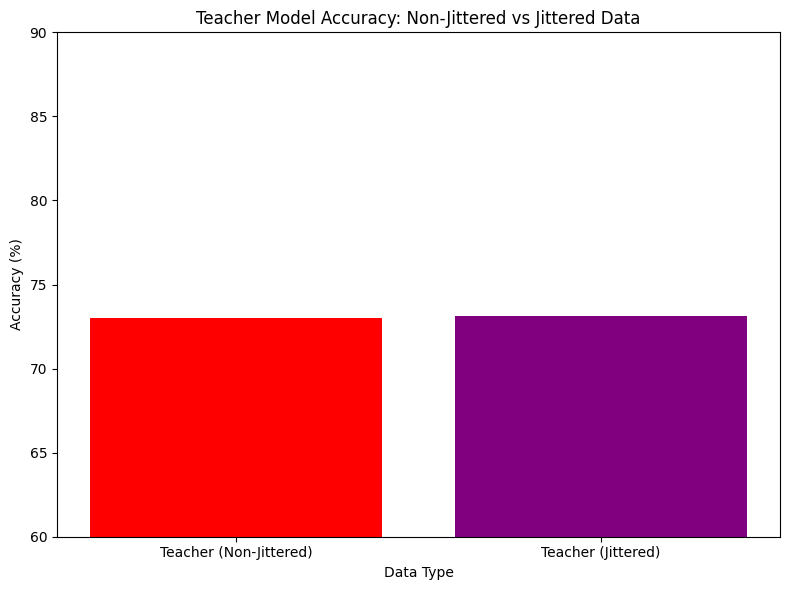

In [1]:
import matplotlib.pyplot as plt

teacher_accuracies = {
    'Teacher (Non-Jittered)': 73.03,  
    'Teacher (Jittered)': 73.14  
}

plt.figure(figsize=(8, 6))
plt.bar(teacher_accuracies.keys(), teacher_accuracies.values(), color=['red', 'purple'])

plt.title('Teacher Model Accuracy: Non-Jittered vs Jittered Data')
plt.xlabel('Data Type')
plt.ylabel('Accuracy (%)')
plt.ylim(60, 90) 
plt.tight_layout()

plt.show()


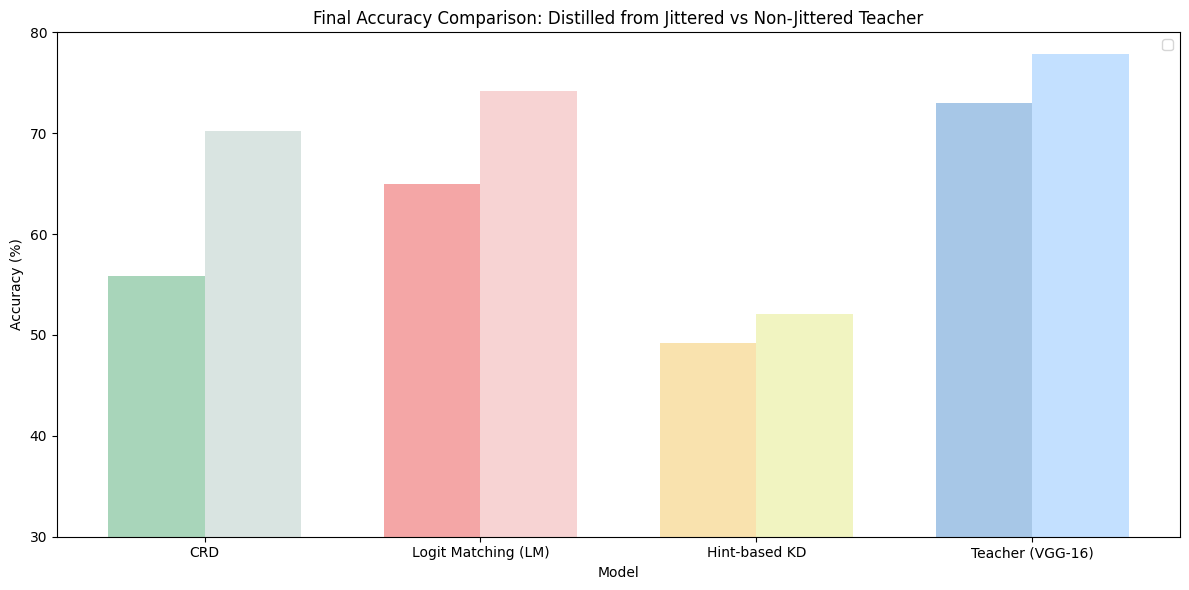

In [38]:
import matplotlib.pyplot as plt
import numpy as np

final_accuracies_jittered = {
    'CRD': 55.85, 
    'Logit Matching (LM)': 64.96, 
    'Hint-based KD': 49.22, 
    'Teacher (VGG-16)': 73.03  
}

final_accuracies_non_jittered = {
    'CRD': 70.19, 
    'Logit Matching (LM)': 74.20, 
    'Hint-based KD': 52.08, 
    'Teacher (VGG-16)': 77.90  
}

bar_width = 0.35
index = np.arange(len(final_accuracies_jittered))

plt.figure(figsize=(12, 6))
plt.bar(index, final_accuracies_jittered.values(), bar_width, color=['#A8D5BA', '#F4A6A6', '#F9E2AE', '#A7C7E7'])  # soft pastel colors
plt.bar(index + bar_width, final_accuracies_non_jittered.values(), bar_width, color=['#D9E4E1', '#F7D3D3', '#F1F4C1', '#C3E0FF'])  # soft pastel colors

plt.title('Final Accuracy Comparison: Distilled from Jittered vs Non-Jittered Teacher')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')

plt.xticks(index + bar_width / 2, final_accuracies_jittered.keys())
plt.legend()
plt.ylim(30, 80)

plt.tight_layout()
plt.show()
